# Module 4 - Trade Call Prediction using Classification

In this module, we'd be covering the concept of classification and utilize our skills to solve the following queries – (Stock Price = Close Price)

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import OrderedDict
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Query 4.1 

Import the csv file of the stock which contained the Bollinger columns as well.

- Create a new column 'Call' , whose entries are - 
    - 'Buy' if the stock price is below the lower Bollinger band 
    - 'Hold Buy/ Liquidate Short' if the stock price is between the lower and middle Bollinger band 
    - 'Hold Short/ Liquidate Buy' if the stock price is between the middle and upper Bollinger band 
    - 'Short' if the stock price is above the upper Bollinger band

- Now train a classification model with the 3 bollinger columns and the stock price as inputs and 'Calls' as output. Check the accuracy on a test set. (There are many classifier models to choose from, try each one out and compare the accuracy for each)

- Import another stock data and create the bollinger columns. Using the already defined model, predict the daily calls for this new stock.

In [3]:
dataframe = pd.read_csv('week3.csv');
def call(row):
    if row['Close Price'] <= row['14_day_bollinger_lower']: return 'Buy'    
    if row['Close Price'] >= row['14_day_bollinger_upper']: return 'Short'
    if row['Close Price'] <=  row['14_day_SMA'] and row['Close Price'] >= row['14_day_bollinger_lower']:  return 'Hold Buy / Liquidate Short'
    if row['Close Price'] >=  row['14_day_SMA'] and row['Close Price'] <= row['14_day_bollinger_upper']:  return 'Hold Short / Liquidate Buy'
    
dataframe['Call'] = dataframe.apply(call, axis=1)
dataframe['Call'].unique()

array([None, 'Hold Short / Liquidate Buy', 'Short',
       'Hold Buy / Liquidate Short', 'Buy'], dtype=object)

- Now train a classification model with the 3 bollinger columns and the stock price as inputs and 'Calls' as output. Check the accuracy on a test set. (There are many classifier models to choose from, try each one out and compare the accuracy for each)

In [4]:
scaler = StandardScaler()

X = dataframe.dropna()[['Close Price', '14_day_STD', '14_day_bollinger_upper', '14_day_bollinger_lower']]
y = dataframe.dropna()['Call']    
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

max_features = len(y.unique())
encoder      = LabelEncoder()

In [5]:
max_features

4

In [6]:
classifiers = OrderedDict([
    ( "Nearest Neighbors", KNeighborsClassifier(max_features) ),
    ( "Linear SVM",        SVC(kernel="linear", C=0.025) ),
    ( "RBF SVM",           SVC(gamma=2, C=1) ),
    ( "Gaussian Process",  GaussianProcessClassifier(1.0 * RBF(1.0)) ),
    ( "Decision Tree",     DecisionTreeClassifier(max_depth=5) ),
    ( "Random Forest",     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=max_features) ),
    ( "Neural Net",        MLPClassifier(alpha=1, max_iter=1000) ),
    ( "AdaBoost",          AdaBoostClassifier() ),
    ( "Naive Bayes",       GaussianNB() ),
    ( "QDA",               QuadraticDiscriminantAnalysis() ),
])

In [7]:
scores = {}
for (name, classifier) in classifiers.items():
  classifier.fit(X_train, y_train)
  scores[name] = classifier.score(X_test, y_test)
    
scores = OrderedDict(sorted(scores.items(), key=lambda x: x[1]))
scores

C:\Users\Sweety\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


OrderedDict([('Naive Bayes', 0.5882352941176471),
             ('Linear SVM', 0.6013071895424836),
             ('Decision Tree', 0.6078431372549019),
             ('AdaBoost', 0.6535947712418301),
             ('QDA', 0.7320261437908496),
             ('Random Forest', 0.7581699346405228),
             ('Nearest Neighbors', 0.7908496732026143),
             ('Gaussian Process', 0.803921568627451),
             ('RBF SVM', 0.8235294117647058),
             ('Neural Net', 0.8758169934640523)])

- Import another stock data and create the bollinger columns. Using the already defined model, predict the daily calls for this new stock.

In [8]:
titan = pd.read_csv('data/Large_Cap/TITAN.csv', parse_dates=['Date']);
titan = titan[ titan.Series == 'EQ' ]
titan.set_index('Date', drop=False, inplace=True)

titan["14_day_SMA"] = titan['Close Price'].rolling(14).mean()
titan["14_day_STD"] = titan['Close Price'].rolling(14).std()
titan["14_day_bollinger_upper"] = titan["14_day_SMA"] + titan["14_day_STD"] * 2
titan["14_day_bollinger_lower"] = titan["14_day_SMA"] - titan["14_day_STD"] * 2

titan   = titan.dropna()  # fit_transform() breaks if NA is present
titan_X = scaler.fit_transform( titan[['Close Price', '14_day_STD', '14_day_bollinger_upper', '14_day_bollinger_lower']] )
titan['Call']      = classifiers["Neural Net"].predict( titan_X )  # using previously trained Neural Network
titan['Call_Code'] = encoder.fit(titan['Call']).transform(titan['Call'])

titan.to_csv('TITAN.csv');

print( "titan['Call'].unique() = ", titan['Call'].unique() )
titan

titan['Call'].unique() =  ['Hold Short / Liquidate Buy' 'Hold Buy / Liquidate Short']


,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,...,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,14_day_SMA,14_day_STD,14_day_bollinger_upper,14_day_bollinger_lower,Call,Call_Code
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,TITAN,EQ,2017-06-01,474.90,475.95,476.45,465.30,468.60,470.70,469.95,...,3.360497e+08,34175,330045,46.16,474.917857,6.788696,488.495248,461.340466,Hold Short / Liquidate Buy,1
2017-06-02,TITAN,EQ,2017-06-02,470.70,472.70,474.60,467.00,469.90,471.75,471.04,...,2.810508e+08,13922,292897,49.09,474.067857,6.341518,486.750893,461.384821,Hold Short / Liquidate Buy,1
2017-06-05,TITAN,EQ,2017-06-05,471.75,511.00,569.20,505.00,551.50,551.85,543.12,...,1.471861e+10,321166,4407918,16.27,478.607143,21.629448,521.866039,435.348247,Hold Short / Liquidate Buy,1
2017-06-06,TITAN,EQ,2017-06-06,551.85,547.00,547.10,521.40,528.75,527.15,531.44,...,5.231674e+09,149354,2501129,25.41,481.850000,25.239065,532.328129,431.371871,Hold Short / Liquidate Buy,1
2017-06-07,TITAN,EQ,2017-06-07,527.15,528.00,547.00,528.00,536.00,536.20,538.09,...,2.622771e+09,72214,1048839,21.52,486.460714,28.867597,544.195908,428.725521,Hold Short / Liquidate Buy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-07,TITAN,EQ,2019-05-07,1082.85,1097.80,1105.00,1083.00,1090.00,1086.50,1094.54,...,2.851972e+09,83154,507973,19.50,1123.207143,24.752839,1172.712820,1073.701466,Hold Buy / Liquidate Short,0
2019-05-08,TITAN,EQ,2019-05-08,1086.50,1090.00,1100.00,1067.85,1096.80,1088.70,1085.83,...,3.623149e+09,92788,472241,14.15,1122.614286,25.516431,1173.647147,1071.581424,Hold Buy / Liquidate Short,0
2019-05-09,TITAN,EQ,2019-05-09,1088.70,1100.00,1110.00,1088.70,1103.20,1104.45,1099.15,...,4.794807e+09,131781,751092,17.22,1123.635714,24.377720,1172.391155,1074.880274,Hold Buy / Liquidate Short,0


##### NOTES:
- MLPClassifier() = ('Neural Net', 0.8627450980392157) was the top performing Classification algroythem 
- MLPClassifier() when run on initial week3 dataset predicts examples of all 4 Call values (exceeds bollenger bands)
- MLPClassifier() when run on Titan datasets only predicts 2 out of the 4 possible Call values (eg never exceeds bollenger bands - which seems wrong)

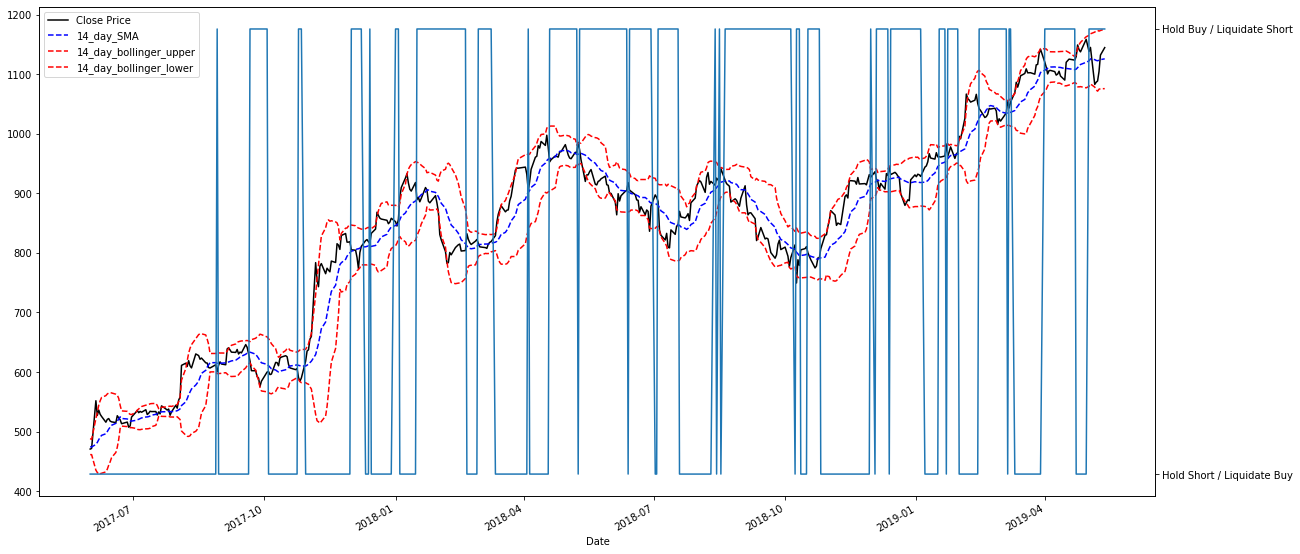

In [9]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.gca()
ax2 = ax1.twinx()


titan.plot(kind='line',x='Date', y='Close Price',             ax=ax1, color='black')
titan.plot(kind='line',x='Date', y='14_day_SMA',              ax=ax1, color='blue', linestyle='--')
titan.plot(kind='line',x='Date', y='14_day_bollinger_upper',  ax=ax1, color='red',  linestyle='--')
titan.plot(kind='line',x='Date', y='14_day_bollinger_lower',  ax=ax1, color='red',  linestyle='--')
ax2.plot( titan['Call'] )

# Query 4.2

Now, we'll again utilize classification to make a trade call, and measure the efficiency of our trading algorithm over the past two years. For this assignment , we will use RandomForest classifier.

- Import the stock data file of your choice

    - Define 4 new columns , whose values are: 
        - % change between Open and Close price for the day 
        - % change between Low and High price for the day 
        - 5 day rolling mean of the day to day % change in Close Price 
        - 5 day rolling std of the day to day % change in Close Price

    - Create a new column 'Action' whose values are: 
        - 1 if next day's price(Close) is greater than present day's. 
        - (-1) if next day's price(Close) is less than present day's. 
        - i.e. Action [ i ] = 1 if Close[ i+1 ] > Close[ i ] 
        - i.e. Action [ i ] = (-1) if Close[ i+1 ] < Close[ i ]


- Construct a classification model with the 4 new inputs and 'Action' as target

- Check the accuracy of this model , also , plot the net cumulative returns (in %) if we were to follow this algorithmic model


In [10]:
dhfl = pd.read_csv('data/Mid_Cap/DHFL.csv', parse_dates=['Date']);
dhfl.set_index('Date', drop=False, inplace=True)

dhfl['Day Perc Change'] = dhfl['Close Price'].pct_change()\
                                           .map(lambda x: x if not math.isnan(x) else 0 ) \
                                           .map(lambda x: x * 100     )  \
                                           .map(lambda x: round(x, 2) )

dhfl['pc_Open_Close'] = ( dhfl['Close Price'] - dhfl['Open Price'] ) / dhfl['Open Price']
dhfl['pc_High_Low']   = ( dhfl['High Price']  - dhfl['Low Price']  ) / dhfl['Low Price']
dhfl['5_day_mean']    = dhfl['Day Perc Change'].rolling(5).mean()
dhfl['5_day_std']     = dhfl['Day Perc Change'].rolling(5).std()
dhfl.dropna(inplace=True)

# Shorthand syntax for the below loop - NOTE: returns NaN for last value, and doesn't deal with == edgecase as 0
dhfl['Action'] = np.where( dhfl['Close Price'].shift(-1) > dhfl['Close Price'], 1, -1 )

# # Create a new column 'Action' whose values are: 
# dhfl.reset_index(drop=True, inplace=True)  # reset to numeric indices 
# for index, today in dhfl.iterrows():
#     try:
#         tomorrow = dhfl.iloc[index+1]    
#         if   tomorrow['Close_Price'] > today['Close_Price']: action_value =  1
#         elif tomorrow['Close_Price'] < today['Close_Price']: action_value = -1
#         else:                                                action_value =  0
#         dhfl.at[index, 'Action'] = action_value;         
#     except: pass  # catch out of bounds error 
# dhfl.set_index('Date', drop=False, inplace=True)  # Restore index

dhfl.to_csv('DHFL.csv');
dhfl

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,...,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,Day Perc Change,pc_Open_Close,pc_High_Low,5_day_mean,5_day_std,Action
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-15,DHFL,NB,2017-05-15,1040.00,1050.00,1050.00,1050.00,1050.00,1050.00,1050.00,...,6300.00,1,6,100.00,-1.87,0.000000,0.000000,27.624,59.567189,1
2017-05-15,DHFL,NC,2017-05-15,1071.00,1070.00,1072.50,1070.00,1072.00,1072.28,1071.94,...,1595041.80,15,1488,100.00,2.12,0.002131,0.002336,28.048,59.328471,1
2017-05-15,DHFL,NH,2017-05-15,1150.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,...,39066.00,1,34,100.00,7.15,0.000000,0.000000,2.658,3.387812,-1
2017-05-15,DHFL,NL,2017-05-15,1044.30,1050.00,1058.00,1040.50,1040.60,1040.60,1040.76,...,192540.25,5,185,100.00,-9.43,-0.008952,0.016819,-0.126,6.122077,1
2017-05-15,DHFL,NN,2017-05-15,1050.00,1050.00,1050.00,1043.00,1043.00,1043.00,1043.83,...,104383.25,5,100,100.00,0.23,-0.006667,0.006711,-0.360,6.071318,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-13,DHFL,NP,2019-05-13,775.00,770.00,770.00,751.01,751.01,754.90,757.54,...,455282.14,44,577,96.01,-6.80,-0.019610,0.025286,-0.906,37.866856,1
2019-05-13,DHFL,NQ,2019-05-13,842.39,969.90,969.90,837.00,838.50,838.50,846.76,...,50805.34,16,46,76.67,11.07,-0.135478,0.158781,6.460,35.319996,-1
2019-05-13,DHFL,NS,2019-05-13,797.90,800.00,800.00,799.99,800.00,800.00,800.00,...,14399.99,4,18,100.00,-4.59,0.000000,0.000013,-7.594,12.425057,-1


In [11]:
X = dhfl.dropna()[['pc_Open_Close', 'pc_High_Low', '5_day_mean', '5_day_std']]
y = dhfl.dropna()['Action']  
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, max_features=4)
random_forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
# Score using the inbult score function
random_forest.fit(X_train,  y_train)
random_forest.score(X_test, y_test)

0.7126741871267419

In [13]:
# Score using sklearn.metrics.accuracy_score(normalize=True) is exactly the same
accuracy_score( y_test, random_forest.predict(X_test), normalize=True )  # normalize=True means give percentage results

0.7126741871267419

In [14]:
#Score using sklearn.metrics.accuracy_score(normalize=False) / len(X_test) = also provides percentage
accuracy_score( y_test, random_forest.predict(X_test), normalize=False ) / len(X_test)

0.7126741871267419

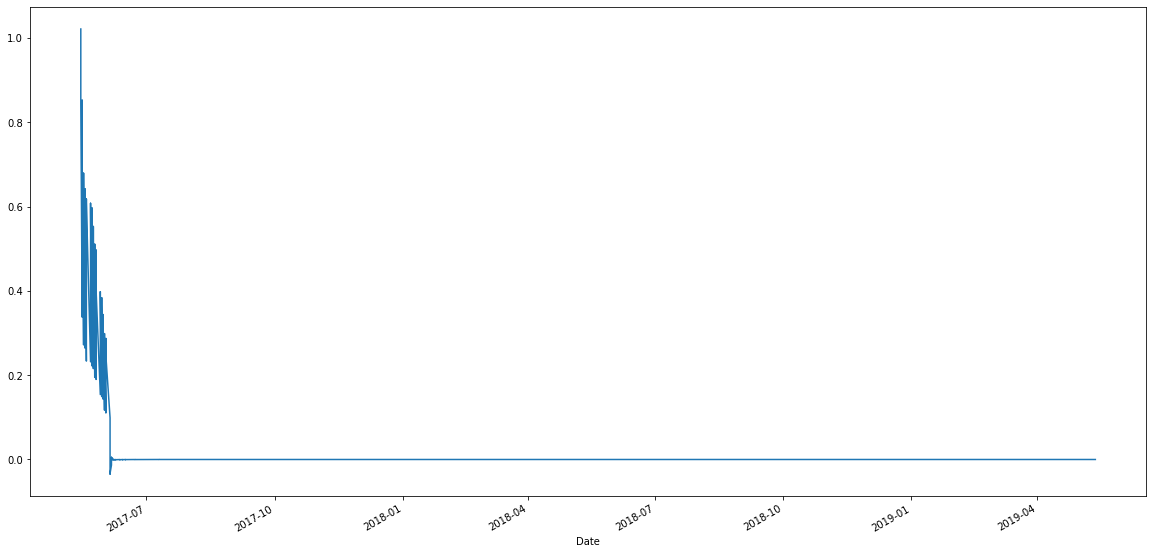

In [15]:
# Cumulative Product of PCT change in Close_Price with predicted actions
cumulative_returns = ( 1 + (dhfl['Close Price'].pct_change() * dhfl['Action']) ).dropna().cumprod()
cumulative_returns.plot(figsize=(20,10))